# 📘 HR Attrition – Template d'analyse (TechNova Partners)

Ce notebook est une **trame prête à l'emploi** pour analyser les **causes de démission** avec une cible **déséquilibrée (~15% de départs)**.

**Sommaire :**
1. Chargement des données 
2. Diagnostic du déséquilibre
3. EDA (numérique & catégorielle) + tests statistiques
4. Pairplot (matrice de dispersion) pour corrélations & multicolinéarité
5. 1ʳᵉ itération : petit modèle (4 variables, 10% des lignes), matrice de confusion
6. 2ᵉ itération : équilibrage (oversampling simple / `class_weight`), features, CV
7. Interprétation globale & locale (importance, SHAP si dispo)
8. Reco RH (espace libre)

# À faire :
https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html 

## 0) Imports & configuration

In [1]:
# === Imports & configuration ===
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, f1_score, recall_score, precision_score, roc_curve, roc_auc_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# à garder ?
from imblearn.over_sampling import SMOTE
import shap

HAS_SHAP = True
HAS_IMBLEARN = True
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1) Paramètres & chemins

In [2]:
from manet_projet04 import load_settings

CFG = load_settings('manet_projet04/settings.yml')

RANDOM_STATE = CFG["RANDOM_STATE"]
PATH_SIRH    = CFG["PATH_SIRH"]
PATH_EVAL    = CFG["PATH_EVAL"]
PATH_SONDAGE = CFG["PATH_SONDAGE"]
COL_ID       = CFG["COL_ID"]
TARGET       = CFG["TARGET"]
NUM_COLS     = CFG["NUM_COLS"]
CAT_COLS     = CFG["CAT_COLS"]
SAT_COLS     = CFG["SAT_COLS"]
FIRST_VARS   = CFG["FIRST_VARS"]
SUBSAMPLE_FRAC = CFG["SUBSAMPLE_FRAC"]

## 2) Chargement, contrôles et assemblage

In [3]:
def safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"[ATTENTION] Lecture impossible {path}: {e}")
        return pd.DataFrame()

sirh = safe_read_csv(PATH_SIRH)
eval_ = safe_read_csv(PATH_EVAL)
sond = safe_read_csv(PATH_SONDAGE)

print('Tailles:', len(sirh), len(eval_), len(sond))

if COL_ID not in sirh.columns:
    raise ValueError(f"La clé {COL_ID} doit exister dans SIRH.")

def ensure_key(df, ref, key):
    if key not in df.columns:
        print(f"[AVERTISSEMENT] {key} absent → alignement par index (provisoire). Voir avec Manuel si c'est normal.")
        n = min(len(df), len(ref))
        df = df.iloc[:n, :].copy()
        ref = ref.iloc[:n, :].copy()
        df[key] = ref[key].values
    return df

eval_ = ensure_key(eval_, sirh, COL_ID)
sond  = ensure_key(sond,  sirh, COL_ID)

df = sirh.merge(eval_, on=COL_ID, how='inner', suffixes=('_sirh','_eval')).merge(sond, on=COL_ID, how='inner')
print('Shape finale:', df.shape)
df.head(3)

Tailles: 1470 1470 1470
[AVERTISSEMENT] id_employee absent → alignement par index (provisoire). Voir avec Manuel si c'est normal.
[AVERTISSEMENT] id_employee absent → alignement par index (provisoire). Voir avec Manuel si c'est normal.
Shape finale: (1470, 34)


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,...,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,3,1,4,2,2,Autre,Y,Occasionnel,0,0


In [4]:
if 'heure_supplementaires' in df.columns:
    if df['heure_supplementaires'].dtype == 'object':
        df['heure_supplementaires'] = df['heure_supplementaires'].str.strip().str.lower().map({'oui':1,'non':0})

sat_presentes = [c for c in SAT_COLS if c in df.columns]
if sat_presentes:
    df['satisfaction_globale'] = df[sat_presentes].mean(axis=1)
    if 'satisfaction_globale' not in NUM_COLS:
        NUM_COLS.append('satisfaction_globale')

## 3) Déséquilibre de la cible (graphique & chiffres)

Effectifs par classe:
 a_quitte_l_entreprise
0    1233
1     237
Name: count, dtype: int64

Répartition (%):
 a_quitte_l_entreprise
0    83.88
1    16.12
Name: count, dtype: float64


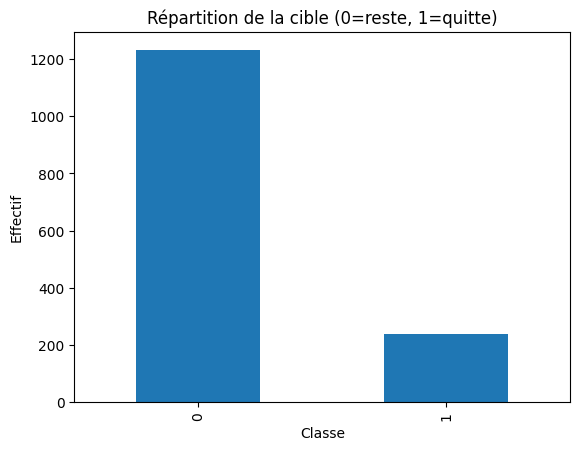

In [5]:
# === Diagnostic du déséquilibre de la cible (version robuste) ===
if TARGET not in df.columns:
    raise ValueError(f"Cible {TARGET} absente. Assurez-vous qu'elle est dans le fichier sondage.")

# Normalisation des valeurs de la cible (convertit oui/non, True/False, etc.)
df[TARGET] = df[TARGET].astype(str).str.strip().str.lower().map({
    '1': 1, '0': 0,
    'oui': 1, 'non': 0,
    'True': 1, 'False': 0,
    'quitte': 1, 'reste': 0
})

# Suppression des valeurs non mappées
df = df[df[TARGET].isin([0, 1])].copy()

# Vérification du contenu
if df.empty or df[TARGET].nunique() < 2:
    raise ValueError(f"La variable cible {TARGET} ne contient pas de valeurs valides (0/1) après nettoyage.")

# Comptage et affichage
counts = df[TARGET].value_counts().sort_index()
ratio = (counts / counts.sum() * 100).round(2)
print('Effectifs par classe:\n', counts)
print('\nRépartition (%):\n', ratio)

# Bar plot sécurisé
if counts.empty:
    print("[INFO] Aucun effectif valide à afficher pour la cible.")
else:
    plt.figure()
    counts.plot(kind='bar')
    plt.title('Répartition de la cible (0=reste, 1=quitte)')
    plt.xlabel('Classe')
    plt.ylabel('Effectif')
    plt.show()

## 4) EDA 

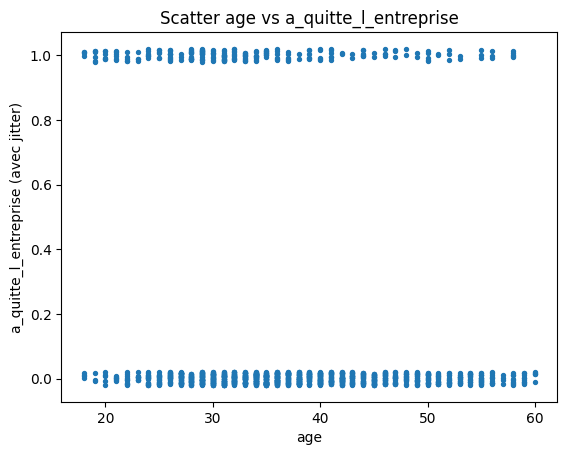

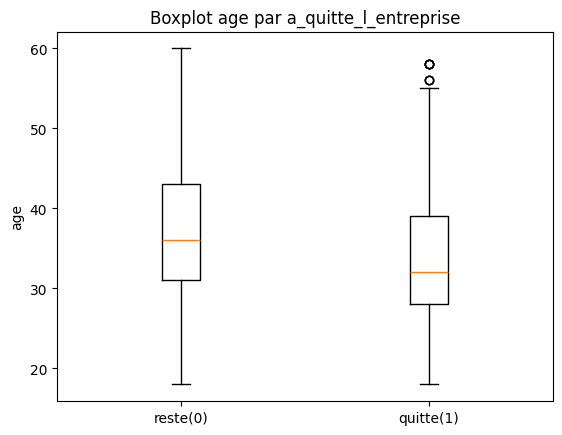

Test Mann-Whitney U sur 'age' → stat=185362.000, p=5.3e-11


In [6]:
# === EDA – Numérique : exemples de graphiques et tests ===
import scipy.stats as stats

def scatter_by_target(df, xcol, target=TARGET):
    # Scatter jitter simple sur l'axe Y pour distinguer les classes
    y = df[target].values + np.random.uniform(-0.02, 0.02, size=len(df))
    plt.figure()
    plt.scatter(df[xcol], y, s=8)
    plt.xlabel(xcol)
    plt.ylabel(target + ' (avec jitter)')
    plt.title(f'Scatter {xcol} vs {target}')
    plt.show()

def box_by_target(df, xcol, target=TARGET):
    # Boxplot via pandas/matplotlib (split par classe)
    plt.figure()
    data0 = df[df[target]==0][xcol].dropna()
    data1 = df[df[target]==1][xcol].dropna()
    plt.boxplot([data0, data1], labels=['reste(0)','quitte(1)'])
    plt.title(f'Boxplot {xcol} par {target}')
    plt.ylabel(xcol)
    plt.show()
    return data0, data1

def numeric_tests(data0, data1):
    # Normalité → Shapiro (sur échantillons <= 5000 pour éviter erreurs)
    d0 = data0.sample(min(len(data0), 5000), random_state=RANDOM_STATE)
    d1 = data1.sample(min(len(data1), 5000), random_state=RANDOM_STATE)
    try:
        p0 = stats.shapiro(d0).pvalue
        p1 = stats.shapiro(d1).pvalue
    except Exception:
        p0 = p1 = 0.0

    normal = (p0>0.05) and (p1>0.05)
    if normal:
        stat, p = stats.ttest_ind(d0, d1, equal_var=False)
        test_name = 't-test (Welch)'
    else:
        stat, p = stats.mannwhitneyu(d0, d1, alternative='two-sided')
        test_name = 'Mann-Whitney U'
    return test_name, stat, p

# Exemple: Age
if 'age' in df.columns:
    scatter_by_target(df.dropna(subset=['age', TARGET]), 'age', TARGET)
    d0, d1 = box_by_target(df, 'age', TARGET)
    tn, st, p = numeric_tests(d0, d1)
    print(f"Test {tn} sur 'age' → stat={st:.3f}, p={p:.3g}")
else:
    print("[INFO] Colonne 'age' absente – passe l'exemple ou adapte les noms.")

## 5) EDA Catégorielle

Dans le code qui suit on cherche à vérifier s'il existe une relation entre les variables qualitatives.

On fait l'hypothèse qu'il existe une relation de dépendance entre a_quitte_l_entreprise et
+ genre (on rejète h)
+ le statut marital (on ne rejète pas h)
+ le département (on ne rejète pas)
+ les enfants (on rejète)


H non rejeté :
* Très forte corrélation
    * poste, niveau_hierarchique_poste, statut_marital
* Corrélation Moyenne (<0.05 mais proche)
    * frequence_deplacement, departement, domaine_etude

H rejeté :
niveau_education, genre, ayant_enfant

In [7]:
# === EDA – Catégorielle : tableaux croisés + Chi2 ===
from itertools import islice

def chi2_for_categorical(df, col, target=TARGET):
    ct = pd.crosstab(df[col], df[target])
    from scipy.stats import chi2_contingency
    chi2, p, dof, exp = chi2_contingency(ct)
    return ct, chi2, p, dof

for col in CAT_COLS:
    if col in df.columns:
        ct, chi2, p, dof = chi2_for_categorical(df.dropna(subset=[col, TARGET]), col, TARGET)
        print(f"\n[Cat: {col}]\n", ct.head())
        print(f"Chi²={chi2:.3f}, dof={dof}, p={p:.3g}")
    else:
        print(f"[INFO] Catégorie '{col}' absente – adapte CAT_COLS.")


[Cat: genre]
 a_quitte_l_entreprise    0    1
genre                          
F                      501   87
M                      732  150
Chi²=1.117, dof=1, p=0.291

[Cat: statut_marital]
 a_quitte_l_entreprise    0    1
statut_marital                 
Célibataire            350  120
Divorcé(e)             294   33
Marié(e)               589   84
Chi²=46.164, dof=2, p=9.46e-11

[Cat: departement]
 a_quitte_l_entreprise    0    1
departement                    
Commercial             354   92
Consulting             828  133
Ressources Humaines     51   12
Chi²=10.796, dof=2, p=0.00453

[Cat: poste]
 a_quitte_l_entreprise     0   1
poste                          
Assistant de Direction  245  47
Cadre Commercial        269  57
Consultant              197  62
Directeur Technique      78   2
Manager                 122   9
Chi²=86.190, dof=8, p=2.75e-15

[Cat: niveau_hierarchique_poste]
 a_quitte_l_entreprise        0    1
niveau_hierarchique_poste          
1                          

## 6) Matrice de dispersion

In [8]:
# === Nettoyage des colonnes numériques pour conversion en float ===
import re

def to_float_clean(val):
    """Convertit proprement les valeurs avec % , € , , etc. en float."""
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, float)):
        return float(val)
    # Nettoyage des caractères non numériques (garde . et , et -)
    val = str(val).strip().replace(',', '.')
    # Supprime tout sauf chiffres, ., - 
    val = re.sub(r'[^0-9\.\-]', '', val)
    try:
        return float(val)
    except ValueError:
        return np.nan

for col in NUM_COLS:
    if col in df.columns:
        # si colonne de type objet => tentative de conversion
        if df[col].dtype == 'object':
            df[col] = df[col].apply(to_float_clean)

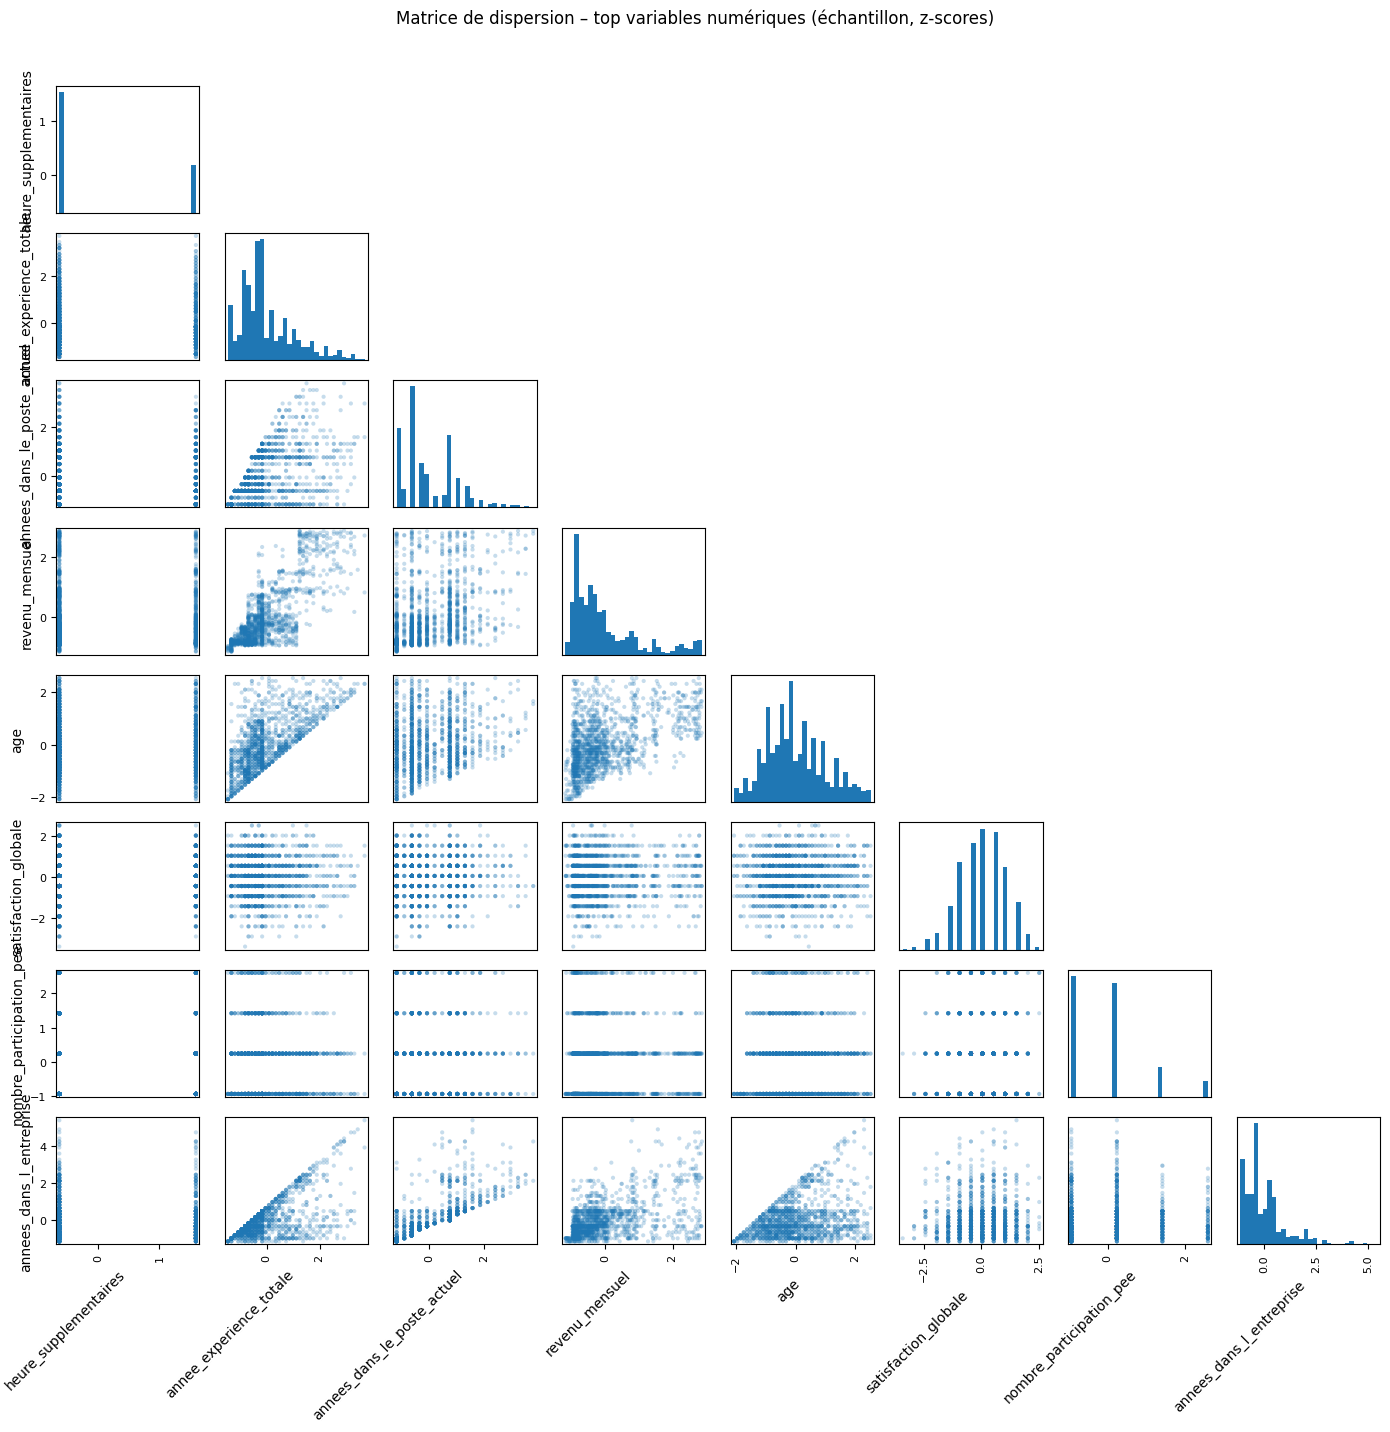

In [9]:
# === Matrice de dispersion ===

# 1) Colonnes numériques présentes
num_cols = [c for c in NUM_COLS if c in df.columns]

dfm = df[num_cols + ([TARGET] if TARGET in df.columns else [])].dropna().copy()

# 2) Downsample pour la lisibilité
MAX_POINTS = 4000
if len(dfm) > MAX_POINTS:
    dfm = dfm.sample(MAX_POINTS, random_state=42)

# 3) Sélection de variables (top corrélées à la cible ou plus grande variance)
TOP_K = 8
if (TARGET in dfm.columns) and (dfm[TARGET].nunique() == 2):
    # corrélation num↔binaire (approx point-biserial via Pearson)
    corr_to_y = dfm[num_cols].apply(lambda s: dfm[TARGET].corr(s))
    cols_sel = corr_to_y.abs().sort_values(ascending=False).head(min(TOP_K, len(num_cols))).index.tolist()
else:
    variances = dfm[num_cols].var().sort_values(ascending=False)
    cols_sel = variances.head(min(TOP_K, len(num_cols))).index.tolist()

if len(cols_sel) < 2:
    print("[INFO] Pas assez de variables numériques pour tracer une matrice de dispersion.")
else:
    # 4) Standardisation pour l’affichage (z-scores)
    Z = dfm[cols_sel].copy()
    Z = (Z - Z.mean()) / Z.std(ddof=0)

    # 5) Matrice de dispersion
    axes = scatter_matrix(
        Z,
        figsize=(14, 14),
        alpha=0.25,
        diagonal='hist',
        hist_kwds={'bins': 30},
        range_padding=0.05
    )

    # 6) Alléger : masquer le triangle supérieur
    n = len(cols_sel)
    for i in range(n):
        for j in range(n):
            if j > i:
                axes[i, j].set_visible(False)

    # 7) Rendre les labels plus lisibles
    for i in range(n):
        # noms de colonnes sur la diagonale du bas et à gauche
        axes[-1, i].set_xlabel(cols_sel[i], rotation=45, ha='right', fontsize=10)
        axes[i, 0].set_ylabel(cols_sel[i], fontsize=10)

    # 8) Mise en page
    plt.suptitle(
        "Matrice de dispersion – top variables numériques (échantillon, z-scores)",
        y=1.02
    )
    plt.tight_layout()
    plt.show()

## 7) Feature engineering

In [10]:
"""# === Feature engineering ===
df_fe = df.copy()

# Ex: augmentation relative du salaire (si colonnes disponibles)
if set(['salaire_avant','salaire_apres']).issubset(df_fe.columns):
    df_fe['augmentation_absolue'] = df_fe['salaire_apres'] - df_fe['salaire_avant']
    df_fe['augmentation_relative'] = df_fe['augmentation_absolue'] / df_fe['salaire_avant'].replace(0, np.nan)
    print('Features ajoutées: augmentation_absolue, augmentation_relative')
else:
    print("[INFO] Pour l'augmentation relative, ajouter 'salaire_avant' et 'salaire_apres'.")

df = df_fe"""

# === Création de nouvelles features calculées ===

# Copie pour éviter les SettingWithCopyWarning
df = df.copy()

# 1. Augmentation relative de salaire
if {'revenu_mensuel', 'augementation_salaire_precedente'}.issubset(df.columns):
    df['augmentation_relative'] = df['augementation_salaire_precedente'] / df['revenu_mensuel']
else:
    print("[INFO] Variables de salaire manquantes → 'augmentation_relative' non calculée.")

# 2. Part d'ancienneté dans l'expérience totale
if {'annees_dans_le_poste_actuel', 'annee_experience_totale'}.issubset(df.columns):
    df['part_experience_dans_poste'] = (
        df['annees_dans_le_poste_actuel'] / df['annee_experience_totale'].replace(0, np.nan)
    )
else:
    print("[INFO] Variables d'expérience manquantes → 'part_experience_dans_poste' non calculée.")

# 3. Formations suivies rapportées à l'expérience
if {'nb_formations_suivies', 'annee_experience_totale'}.issubset(df.columns):
    df['formations_par_an_experience'] = (
        df['nb_formations_suivies'] / df['annee_experience_totale'].replace(0, np.nan)
    )

# 4. Score moyen global de satisfaction
sat_cols = [
    'satisfaction_employee_environnement',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso'
]
sat_cols_exist = [c for c in sat_cols if c in df.columns]
if sat_cols_exist:
    df['satisfaction_moyenne'] = df[sat_cols_exist].mean(axis=1)

# 5. Temps depuis la dernière promotion relatif à l'expérience
if {'annees_depuis_la_derniere_promotion', 'annee_experience_totale'}.issubset(df.columns):
    df['temps_depuis_promo_ratio'] = (
        df['annees_depuis_la_derniere_promotion'] / df['annee_experience_totale'].replace(0, np.nan)
    )

# 6. Évolution de la note de performance
if {'note_evaluation_actuelle', 'note_evaluation_precedente'}.issubset(df.columns):
    df['evolution_note'] = (
        df['note_evaluation_actuelle'] - df['note_evaluation_precedente']
    )

# Nettoyage : remplacer les infinis par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("✅ Nouvelles features créées :", [
    c for c in [
        'augmentation_relative',
        'part_experience_dans_poste',
        'formations_par_an_experience',
        'satisfaction_moyenne',
        'temps_depuis_promo_ratio',
        'evolution_note'
    ] if c in df.columns
])


✅ Nouvelles features créées : ['augmentation_relative', 'part_experience_dans_poste', 'formations_par_an_experience', 'satisfaction_moyenne', 'temps_depuis_promo_ratio', 'evolution_note']


## 8) 1ʳᵉ itération – Modèle léger + matrice de confusion

[ATTENTION] Moins de 2 variables disponibles pour la 1ʳᵉ itération.


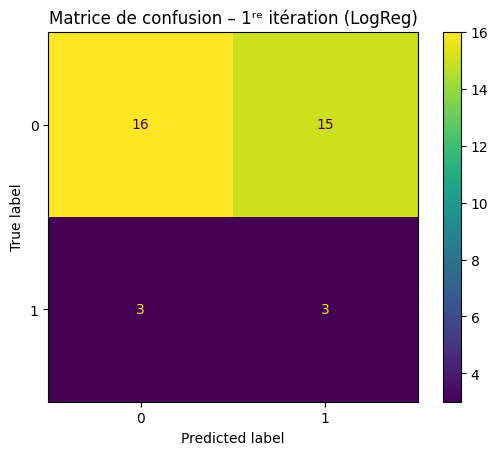

              precision    recall  f1-score   support

           0      0.842     0.516     0.640        31
           1      0.167     0.500     0.250         6

    accuracy                          0.514        37
   macro avg      0.504     0.508     0.445        37
weighted avg      0.733     0.514     0.577        37

ROC-AUC: 0.5483870967741935


In [11]:
# === 1ʳᵉ itération : 4 variables, 10% des lignes ===

first_vars = [c for c in ['age','salaire','anciennete','note_performance'] if c in df.columns]
if len(first_vars) < 2:
    print('[ATTENTION] Moins de 2 variables disponibles pour la 1ʳᵉ itération.')

df_sub = df.dropna(subset=first_vars + [TARGET]).copy()
if len(df_sub) > 0:
    df_sub = df_sub.sample(frac=min(SUBSAMPLE_FRAC, 1.0), random_state=RANDOM_STATE) if len(df_sub) > 100 else df_sub
    X = df_sub[first_vars]
    y = df_sub[TARGET].astype(int)

    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preproc = ColumnTransformer([('num', num_pipe, first_vars)], remainder='drop')

    clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
    pipe = Pipeline([('prep', preproc), ('clf', clf)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1]

    # Matrice de confusion (métrique principale)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title('Matrice de confusion – 1ʳᵉ itération (LogReg)')
    plt.show()

    print(classification_report(y_test, y_pred, digits=3))
    print('ROC-AUC:', roc_auc_score(y_test, y_prob))
else:
    print('[ATTENTION] Pas assez de données nettoyées pour la 1ʳᵉ itération.')

## 9) 2ᵉ itération – Équilibrage + modèles + CV

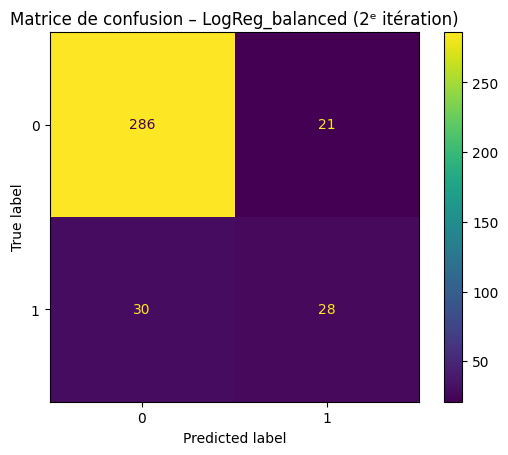

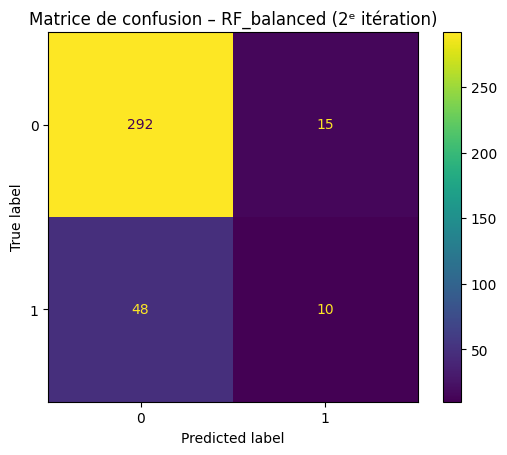


=== Résultats (2ᵉ itération) ===


,model,F1_test,Recall_test,Precision_test,ROC_AUC_test,F1_CV_mean,F1_CV_std
0,LogReg_balanced,0.523364,0.482759,0.571429,0.804167,0.499781,0.025064
1,RF_balanced,0.240964,0.172414,0.400000,0.769039,0.202819,0.050732


In [12]:
# === 2ᵉ itération : équilibrage + modèles robustes + CV ===
# Préparation colonnes finales
ALL_NUM = [c for c in NUM_COLS if c in df.columns]
ALL_CAT = [c for c in CAT_COLS if c in df.columns]

df2 = df.dropna(subset=ALL_NUM + [TARGET]).copy() if ALL_NUM else df.copy()
df2 = df2[df2[TARGET].isin([0,1])]

X_num = df2[ALL_NUM] if ALL_NUM else pd.DataFrame(index=df2.index)
X_cat = pd.get_dummies(df2[ALL_CAT], drop_first=True) if ALL_CAT else pd.DataFrame(index=df2.index)
X_full = pd.concat([X_num, X_cat], axis=1)
y_full = df2[TARGET].astype(int)

# Oversampling simple si imblearn indispo
def simple_oversample(X, y, minority=1, random_state=RANDOM_STATE):
    Xy = X.copy()
    Xy['__y__'] = y.values
    counts = Xy['__y__'].value_counts()
    if len(counts) < 2:
        return X, y
    maj_class = counts.idxmax()
    min_class = counts.idxmin()
    n_maj = counts[maj_class]
    n_min = counts[min_class]
    if n_min == 0:
        return X, y
    need = n_maj - n_min
    X_min = Xy[Xy['__y__'] == min_class]
    sampled = X_min.sample(n=need, replace=True, random_state=random_state)
    X_bal = pd.concat([Xy, sampled], axis=0)
    y_bal = X_bal['__y__'].astype(int).values
    X_bal = X_bal.drop(columns='__y__')
    return X_bal, y_bal

# Pipeline prétraitement
num_pipe2 = Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())])
preproc2 = ColumnTransformer([('num', num_pipe2, list(X_num.columns))], remainder='passthrough')

# Modèles: (a) LogReg ponderée, (b) RandomForest class_weight
models = {
    'LogReg_balanced': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE),
    'RF_balanced': RandomForestClassifier(
        n_estimators=400, max_depth=None, class_weight='balanced_subsample', random_state=RANDOM_STATE
    )
}

# Option SMOTE si dispo
use_smote = HAS_IMBLEARN

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
for name, base_model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.25, stratify=y_full, random_state=RANDOM_STATE)

    X_tr, y_tr = X_train, y_train
    if use_smote:
        sm = SMOTE(random_state=RANDOM_STATE)
        X_tr, y_tr = sm.fit_resample(X_tr, y_tr)
    else:
        X_tr, y_tr = simple_oversample(X_tr, y_tr)

    pipe2 = Pipeline([('prep', preproc2), ('clf', base_model)])
    pipe2.fit(X_tr, y_tr)

    y_pred = pipe2.predict(X_test)
    if hasattr(pipe2, 'predict_proba'):
        y_prob = pipe2.predict_proba(X_test)[:,1]
    else:
        # Approx proba via decision_function si dispo
        try:
            from sklearn.metrics import minmax_scale
            y_prob = minmax_scale(pipe2.decision_function(X_test))
        except Exception:
            y_prob = (y_pred==1).astype(float)

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f'Matrice de confusion – {name} (2ᵉ itération)')
    plt.show()

    f1 = f1_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    # CV (sur F1 pour la classe 1)
    scores = cross_val_score(pipe2, X_full, y_full, cv=cv, scoring='f1')
    results.append({'model': name, 'F1_test': f1, 'Recall_test': rec, 'Precision_test': prec, 'ROC_AUC_test': roc, 'F1_CV_mean': scores.mean(), 'F1_CV_std': scores.std()})

res_df = pd.DataFrame(results).sort_values(by='F1_test', ascending=False)
print('\n=== Résultats (2ᵉ itération) ===')
display(res_df)

## 10) Interprétation : importance globale & locale (SHAP si dispo)

Meilleur modèle (selon F1_test): LogReg_balanced

Top coefficients (LogReg):


,feature,coef
29,poste_Cadre Commercial,2.805780
37,domaine_etude_Entrepreunariat,2.790823
39,domaine_etude_Marketing,2.610734
42,frequence_deplacement_Frequent,2.590900
33,poste_Représentant Commercial,2.531828
7,note_evaluation_precedente,-2.296098
38,domaine_etude_Infra & Cloud,1.979739
41,domaine_etude_Transformation Digitale,1.914219
20,evolution_note,-1.859306
43,frequence_deplacement_Occasionnel,1.829723


<Figure size 700x500 with 0 Axes>

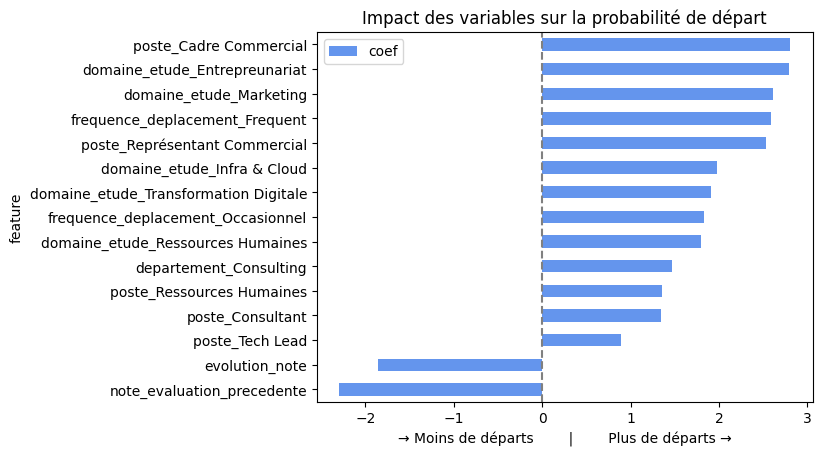

[INFO] SHAP non produit: The passed model is not callable and cannot be analyzed directly with the given masker! Model: LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)


In [13]:
# === Interprétation globale & locale ===

# Choix du meilleur modèle basé sur F1_test
if 'res_df' in globals() and not res_df.empty:
    best_name = res_df.iloc[0]['model']
    print('Meilleur modèle (selon F1_test):', best_name)
else:
    best_name = None

if best_name:
    # Refit sur tout l'ensemble pour extraire importances
    base_model = {
        'LogReg_balanced': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE),
        'RF_balanced': RandomForestClassifier(n_estimators=400, class_weight='balanced_subsample', random_state=RANDOM_STATE)
    }[best_name]

    pipe_best = Pipeline([('prep', preproc2), ('clf', base_model)])
    X_bal, y_bal = (SMOTE(random_state=RANDOM_STATE).fit_resample(X_full, y_full) if HAS_IMBLEARN else simple_oversample(X_full, y_full))
    pipe_best.fit(X_bal, y_bal)

    # Importance globale (si RF ou si LogReg via coefficients)
    try:
        clf = pipe_best.named_steps['clf']
        if isinstance(clf, RandomForestClassifier):
            # Récupérer noms de features après prétraitement
            feature_names = list(X_num.columns) + list(X_cat.columns)
            importances = getattr(clf, 'feature_importances_', None)
            if importances is not None:
                imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(15)
                print('\nTop importances (globales):')
                display(imp_df)
                plt.figure(figsize=(7,5))
                imp_df.sort_values('coef').plot.barh(x='feature', y='coef', color='cornflowerblue')
                plt.axvline(0, color='grey', linestyle='--')
                plt.title("Impact des variables sur la probabilité de départ")
                plt.xlabel("→ Moins de départs        |        Plus de départs →")
                plt.show()
        elif isinstance(clf, LogisticRegression):
            feature_names = list(X_num.columns) + list(X_cat.columns)
            coefs = clf.coef_.ravel()
            imp_df = pd.DataFrame({'feature': feature_names, 'coef': coefs}).reindex(np.argsort(np.abs(coefs))[::-1]).head(15)
            print('\nTop coefficients (LogReg):')
            display(imp_df)
            plt.figure(figsize=(7,5))
            imp_df.sort_values('coef').plot.barh(x='feature', y='coef', color='cornflowerblue')
            plt.axvline(0, color='grey', linestyle='--')
            plt.title("Impact des variables sur la probabilité de départ")
            plt.xlabel("→ Moins de départs        |        Plus de départs →")
            plt.show()
    except Exception as e:
        print('[INFO] Importance globale non disponible:', e)

    # Interprétation locale avec SHAP (si dispo)
    if HAS_SHAP:
        try:
            X_sample = X_full.sample(n=min(400, len(X_full)), random_state=RANDOM_STATE)
            explainer = shap.Explainer(pipe_best.named_steps['clf'])
            shap_values = explainer(X_sample)
            shap.plots.beeswarm(shap_values, show=True)
        except Exception as e:
            print('[INFO] SHAP non produit:', e)
else:
    print('[INFO] Pas de meilleur modèle identifié pour interprétation.')